In [14]:
import warnings
warnings.filterwarnings(action='ignore')

import os
# operating system 운영체제를 의미.
from datetime import datetime
import re
# 정규표현처리를 위한 함수
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = "Malgun Gothic"
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.decomposition import PCA

from pycaret.regression import *

import optuna
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution
from optuna.integration import OptunaSearchCV

from konlpy.tag import Okt
tagger = Okt()

ModuleNotFoundError: No module named 'pycaret'

In [361]:
DATA_PATH = 'data'
SUMIT_PATH = 'submission'

In [362]:
X_train = pd.read_csv(os.path.join(DATA_PATH, 'X_train.csv'), encoding='cp949', index_col='ID')
y_train = pd.read_csv(os.path.join(DATA_PATH, 'y_train.csv'), index_col='ID')

X_test = pd.read_csv(os.path.join(DATA_PATH, 'X_test.csv'), encoding='cp949', index_col='ID')
submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission(검증용).csv'))

In [363]:
X = pd.concat([X_train, X_test], axis=0)

### 결측값 처리

In [364]:
X['직무태그'] = X['직무태그'].fillna('없음')
X['근무형태'] = X['근무형태'].fillna('기타')
X['대학성적'] = X['대학성적'].fillna(X['대학성적'].median())
X['어학시험'] = list(map(lambda x: x if x else np.nan, X['어학시험']))

# Feature Engineering

### Normalize terms - `대학전공`, `어학시험`, `근무형태`, `근무지역`, `자격증`

#### `대학전공`

In [367]:
major = pd.read_csv(os.path.join(DATA_PATH, 'univ_edit_new.csv'))

In [368]:
major_map = {key:value for key, value in zip(major['대학전공'], major['전공분류'])}

In [369]:
X['대학전공'] = X['대학전공'].map(major_map).fillna('기타')

In [370]:
# train['대학전공'] = train['대학전공'].map(major_map).fillna('기타')
# test['대학전공'] = test['대학전공'].map(major_map).fillna('기타')

#### `어학시험`

In [371]:
# 어학시험 값 대치

lang = {'JLPT':'일본어', 'JPT':'일본어', 'TOEIC':'영어', 'IELTS':'영어', 'TOEFL':'영어', 'TEPS':'영어', 'HSK':'중국어',
       'JTRA':'일본어', '기타':'기타', 'TOEFL-PBT':'영어', 'G-ETAT':'영어', 'G-TELP':'영어', '기타시험':'기타', 'TOEFL-CBT':'영어',
       'GRE':'영어', 'OPIc':'영어', 'G-TELP(GLT)':'영어', 'DALF':'영어', 'TOEIC Speaking':'영어', 'SEPT':'영어',
       'DELF':'프랑스어', 'TOEFL-IBT':'영어', 'TOEIC S&W':'영어', '新HSK':'중국어', 'OPI':'영어', 'DELE':'프랑스어', 'TORFL':'영어'}

In [372]:
X['어학시험'] = X['어학시험'].map(lang).fillna('없음')

In [373]:
# train['어학시험'] = train['어학시험'].map(lang).replace('', np.nan)
# test['어학시험'] = test['어학시험'].map(lang).replace('', np.nan)

In [374]:
# train['어학시험'].fillna('NA', inplace=True)
# test['어학시험'].fillna('NA', inplace=True)

#### `근무형태`, `근무형태개수`, `근무형태등급`

- 낮은 숫자일수록 높은 등급을 의미
```python
{'인턴':6, '병역특례':5, '파견직':4, '기타':4, '계약직':3, '정규직':2, '해외취업':1}
```

In [375]:
X['근무형태개수'] = X['근무형태'].fillna('기타').str.split(',').str.len()

In [376]:
def normalize_hiring_type(x):
    if '병역특례' in x: return '병역특례'
    elif '인턴' in x: return '인턴'
    elif '해외취업' in x: return '해외취업'
    elif '파견직' in x: return '파견직'
    elif '계약직' in x: return '계약직'
    elif '정규직' in x: return '정규직'
    else: return '기타'

In [377]:
X['근무형태'] = X['근무형태'].fillna('기타').apply(normalize_hiring_type)

In [378]:
X['근무형태등급'] = X['근무형태'].map({'기타':'4', '인턴':'6', '병역특례':'5', '파견직':'4', '계약직':'3', '정규직':'2', '해외취업':'1'})

#### `근무지역`, `근무지역개수`, `근무지역해외포함`

In [379]:
X['근무지역'] = X['근무지역'].apply(lambda x : '_'.join(set([y for y in x.split(',') if y])))

In [380]:
X['근무지역개수'] = X['근무지역'].str.split('_').str.len()

In [381]:
abroad_keywords = ['대만', '러시아', '말레이시아', '미국', '방글라데시', '싱가포르', '인도', 
                   '인도네시아', '일본', '중국', '캐나다', '프랑스', '필리핀', '해외', '홍콩']

In [382]:
X['근무지역해외포함'] = X['근무지역'].apply(lambda x : x in abroad_keywords).astype(float)

#### `자격증`

In [383]:
X['자격증'] = X['자격증'].map({'無':0.0, '有':1.0})

#### `직무태그`, `직무태그개수`, `직무태그해외관련`, `표준화직무태그`

- 대표직무태그 압축
- 기술사전 사용 필요

In [384]:
stopwords = []
with open('data/stopwords_직무태그.txt') as f:
    for line in f.readlines():
        stopwords.append(line.strip())

In [385]:
X['직무태그'] = X['직무태그'].apply(lambda x: re.sub('|'.join(stopwords), '', x))

In [386]:
X['직무태그개수'] = X['직무태그'].str.split(',').apply(lambda x : 0 if '없음' in x else len(x))

In [387]:
X['직무태그해외관련'] = X['직무태그'].str.contains('해외').astype(int)

In [388]:
ncs = pd.read_excel('data/NCS.xlsx', sheet_name=1)

In [389]:
core_keywords = []
for col in ncs.columns:
    core_keywords += ncs[col].unique().tolist()
    
core_keywords = np.array(core_keywords)

In [390]:
def normalize_jobtag(x):
    return_core_keywords = []
    for keyword in x.split(','):
        return_core_keywords += list(core_keywords[np.where(core_keywords==keyword)[0]])
    return '_'.join(list(set(return_core_keywords)))

In [391]:
X['표준화직무태그'] = X['직무태그'].apply(normalize_jobtag)

In [392]:
X['표준화직무태그'] = X['표준화직무태그'].apply(lambda x : x if x else '기타')

### Convert to Numeric - `근무경력`

#### `근무경력`
- 문자열로 코딩되어 있는 값을 숫자로 변환

In [393]:
def get_duration(x):
    is_duration = re.compile('[0-9]+')
    A, *B = is_duration.findall(x)
    if B:
        if int(A) >= 40:
            _, *a2 = A
            return int(a2[0])*12 + int(B[0])
        else: return int(A)*12 + int(B[0])
    else: return int(A)

In [394]:
X['근무경력'] = X['근무경력'].apply(get_duration)

In [395]:
X.columns

Index(['직종', '세부직종', '직무태그', '근무경력', '근무형태', '근무지역', '출신대학', '대학전공', '어학시험',
       '자격증', '대학성적', '근무형태개수', '근무형태등급', '근무지역개수', '근무지역해외포함', '직무태그개수',
       '직무태그해외관련', '표준화직무태그'],
      dtype='object')

### Derived features


- `직종` - `대표직종`, `직종의 개수`
- `세부직종` - `세부직종의 개수`
- `출신대학` - `출신대학의 등급`, `출신대학 지역`, `대학종합점수`
- `직무태그개수`, `직종개수` - `직종대비직무태그수`
- `근무지역` - `대표근무지역`
- `근무경력`, `근무형태등급` - `경력인정점수`

#### `대표직종`

In [396]:
X['대표직종'] = X['직종'].str.split('·').str.get(0).fillna('기타 직종')

In [397]:
X['대표직종2'] = X['직종'].str.split('·').str.get(1).fillna('기타 직종')

#### `직종개수`

In [398]:
X['직종개수'] = X['직종'].str.split('·').str.len()

#### `세부직종개수`

In [399]:
X['세부직종개수'] = X['세부직종'].str.split('·').str.len()

#### `출신대학등급`

- 낮을 수록 높은 등급을 의미

In [400]:
univ_tiers = {1: ['연세대학교'],
              2: ['이화여자대학교', '성균관대학교', '중앙대학교'],
              3: ['세종대학교', '서울과학기술대학교', '성신여자대학교'],
              4: ['동덕여자대학교', '경기대학교', '한성대학교', '인천대학교'],
              5: ['서울여자대학교', '제주대학교', '목포대학교', '호남대학교', '성공회대학교', '한림대학교', '군산대학교'],
              6: ['동아대학교', '한국산업기술대학교', '수원대학교', '세명대학교', '용인대학교', '부산디지털대학교', '전주대학교'],
              7: ['광주대학교', '서원대학교', '선문대학교', '경주대학교'],
              8: ['서울신학대학교', '성결대학교', '동의대학교', '상지대학교'],
              9: ['한밭대학교', '신라대학교', '호원대학교', '한일장신대학교', '협성대학교', '동서대학교', '한세대학교', '송원대학교', '남부대학교']}

tier_map = {v:str(key) for key, value in univ_tiers.items() for v in value}

In [401]:
X['출신대학등급'] = X['출신대학'].map(tier_map)

#### `출신대학지역`

- 서울, 수도권, 지방으로 구분
```python
{'서울':1, '경기권':2, '지방':3}
```

In [402]:
loc_map = {1:['연세대학교', '이화여자대학교', '성균관대학교', '중앙대학교', '세종대학교', '서울과학기술대학교', 
              '성신여자대학교', '동덕여자대학교', '한성대학교', '서울여자대학교', '성공회대학교'],
           2:['경기대학교', '인천대학교', '한국산업기술대학교', '수원대학교', '용인대학교', '성결대학교', '서울신학대학교', '협성대학교', '한세대학교'],
           3:['한림대학교', '군산대학교', '제주대학교', '목포대학교', '호남대학교', '동아대학교', '광주대학교', '세명대학교', '서원대학교', '부산디지털대학교', 
              '전주대학교', '선문대학교', '경주대학교','동의대학교', '상지대학교', '한밭대학교', '신라대학교', '호원대학교', '한일장신대학교', '동서대학교', 
              '송원대학교', '남부대학교']}

loc_map = {v:str(key) for key, value in loc_map.items() for v in value}

In [403]:
X['출신대학지역'] = X['출신대학'].apply(lambda x: loc_map[x])

#### `대학종합점수`
- 위치와 등급에 따른 임의의 종합점수
- 낮을 수록 높은 등급을 의미

In [404]:
X['대학종합점수'] = X['출신대학등급'].astype(int) * X['출신대학지역'].astype(int)

#### `직종대비직무태그수`

- 직종 1단위당 담당하는 직무태그의 수가 얼마나 많은지.. 하는일이 얼마나 많은지..

In [405]:
X['직종대비직무태그수'] = X['직무태그개수'] / X['직종개수']

#### `대표근무지역`

In [406]:
loc_map = {'강원':'강원', '경기':'경기', '경남':'경남', '경북':'경북', '광주':'전남', '기타':'기타', '대구':'경북', '대만':'해외', '대전':'충남', 
           '러시아':'해외', '말레이시아':'해외', '미국':'해외', '방글라데시':'해외', '부산':'경남', '서울':'서울', '세종':'충남', '싱가포르':'해외',
           '울산':'경남', '인도':'해외', '인도네시아':'해외', '인천':'경기', '일본':'해외', '전국':'전국', '전남':'전남', '전북':'전북', '제주':'제주',
           '중국':'해외','충남':'충남', '충북':'충북', '캐나다':'해외', '프랑스':'해외', '필리핀':'해외', '해외':'해외', '홍콩':'해외'}

In [407]:
X['대표근무지역'] = X['근무지역'].str.split('_').str.get(0).map(loc_map).fillna('전국')

#### `경력인정점수`

- 계약직 10년과 정규직 10년은 다른 경력
- 따라서, 경력 / 등급으로 인정점수를 산출

In [408]:
X['경력인정점수'] = X['근무경력'] / X['근무형태등급'].astype(int)

# EDA

In [409]:
Xy = pd.concat([X.loc[X_train.index], y_train], axis=1)

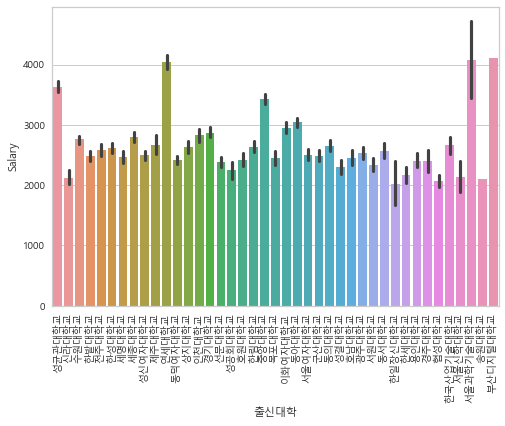

In [366]:
sns.barplot(x = '출신대학', y = 'Salary', data = Xy)
plt.xticks(rotation=90);

In [410]:
Xy.columns

Index(['직종', '세부직종', '직무태그', '근무경력', '근무형태', '근무지역', '출신대학', '대학전공', '어학시험',
       '자격증', '대학성적', '근무형태개수', '근무형태등급', '근무지역개수', '근무지역해외포함', '직무태그개수',
       '직무태그해외관련', '표준화직무태그', '대표직종', '대표직종2', '직종개수', '세부직종개수', '출신대학등급',
       '출신대학지역', '대학종합점수', '직종대비직무태그수', '대표근무지역', '경력인정점수', 'Salary'],
      dtype='object')

### 직종에 따른 근무지역별 임금차이

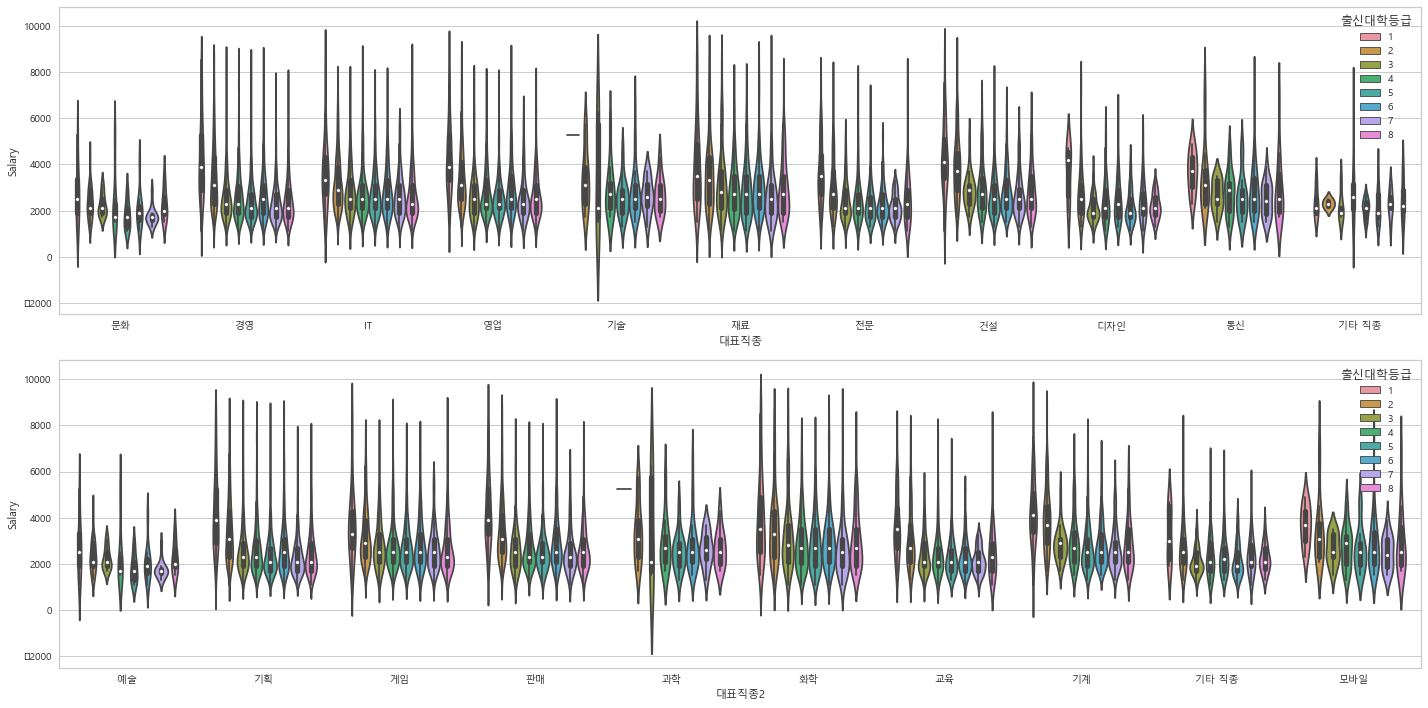

In [411]:
plt.figure(figsize = (20, 10))
plt.subplot(2, 1, 1)
sns.violinplot(x='대표직종', y='Salary', hue='출신대학등급', data=Xy, hue_order=[str(i) for i in range(1, 9)])
plt.subplot(2, 1, 2)
sns.violinplot(x='대표직종2', y='Salary', hue='출신대학등급', data=Xy, hue_order=[str(i) for i in range(1, 9)])
plt.tight_layout()

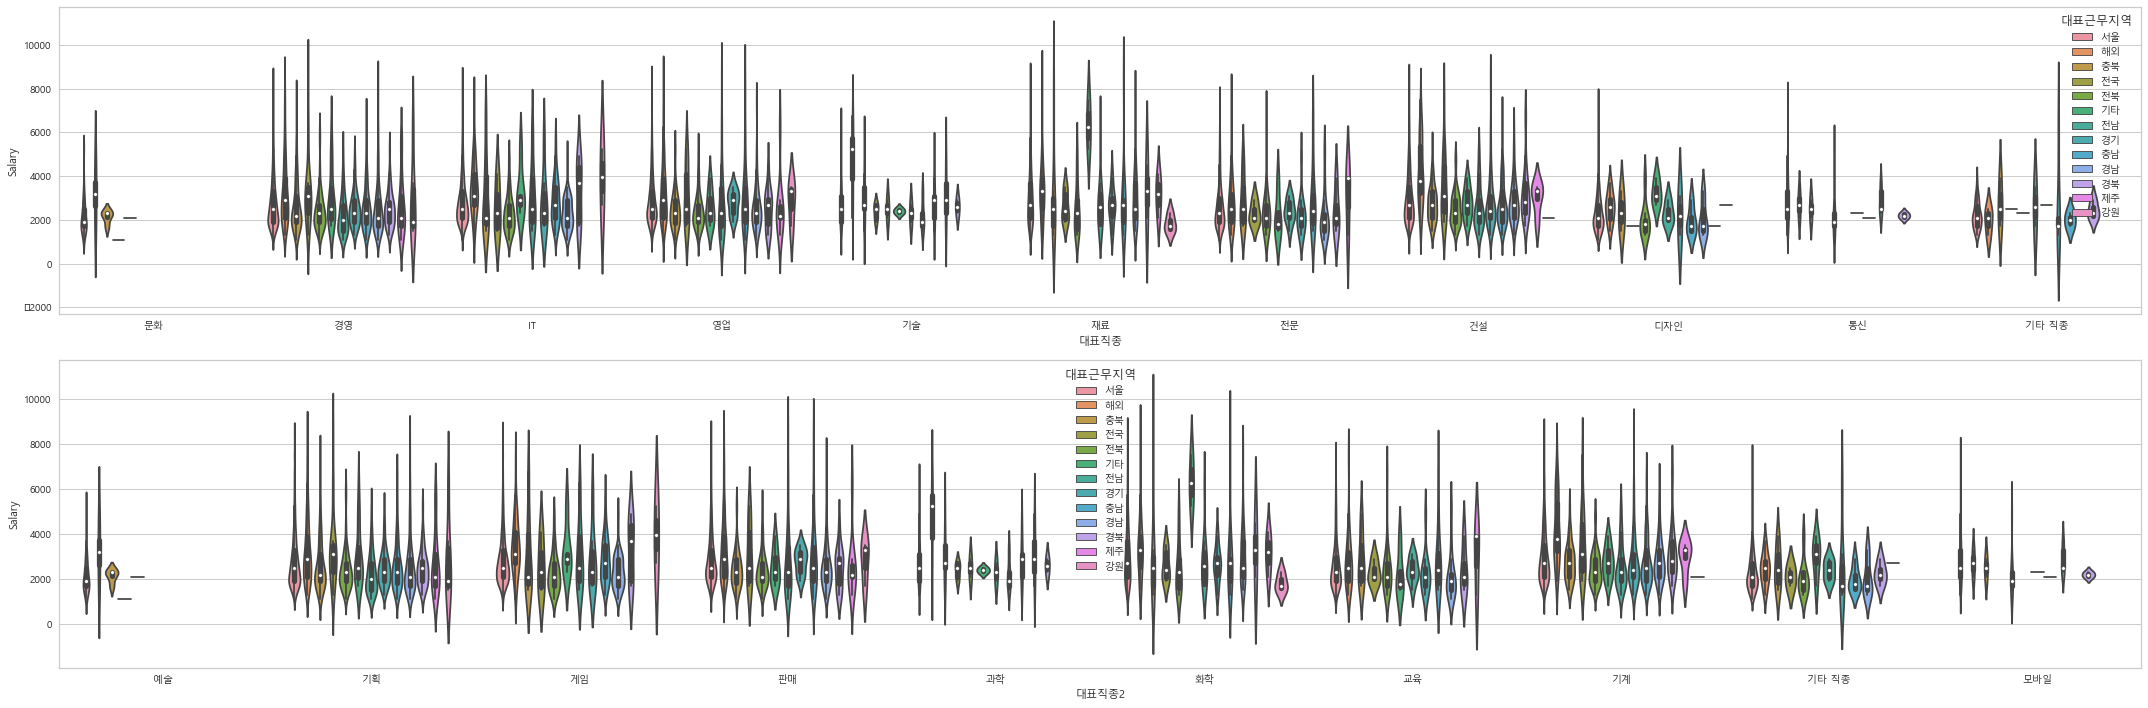

In [412]:
plt.figure(figsize = (30, 10))
plt.subplot(2, 1, 1)
sns.violinplot(x='대표직종', y='Salary', hue='대표근무지역', data=Xy)
plt.subplot(2, 1, 2)
sns.violinplot(x='대표직종2', y='Salary', hue='대표근무지역', data=Xy)
plt.tight_layout()

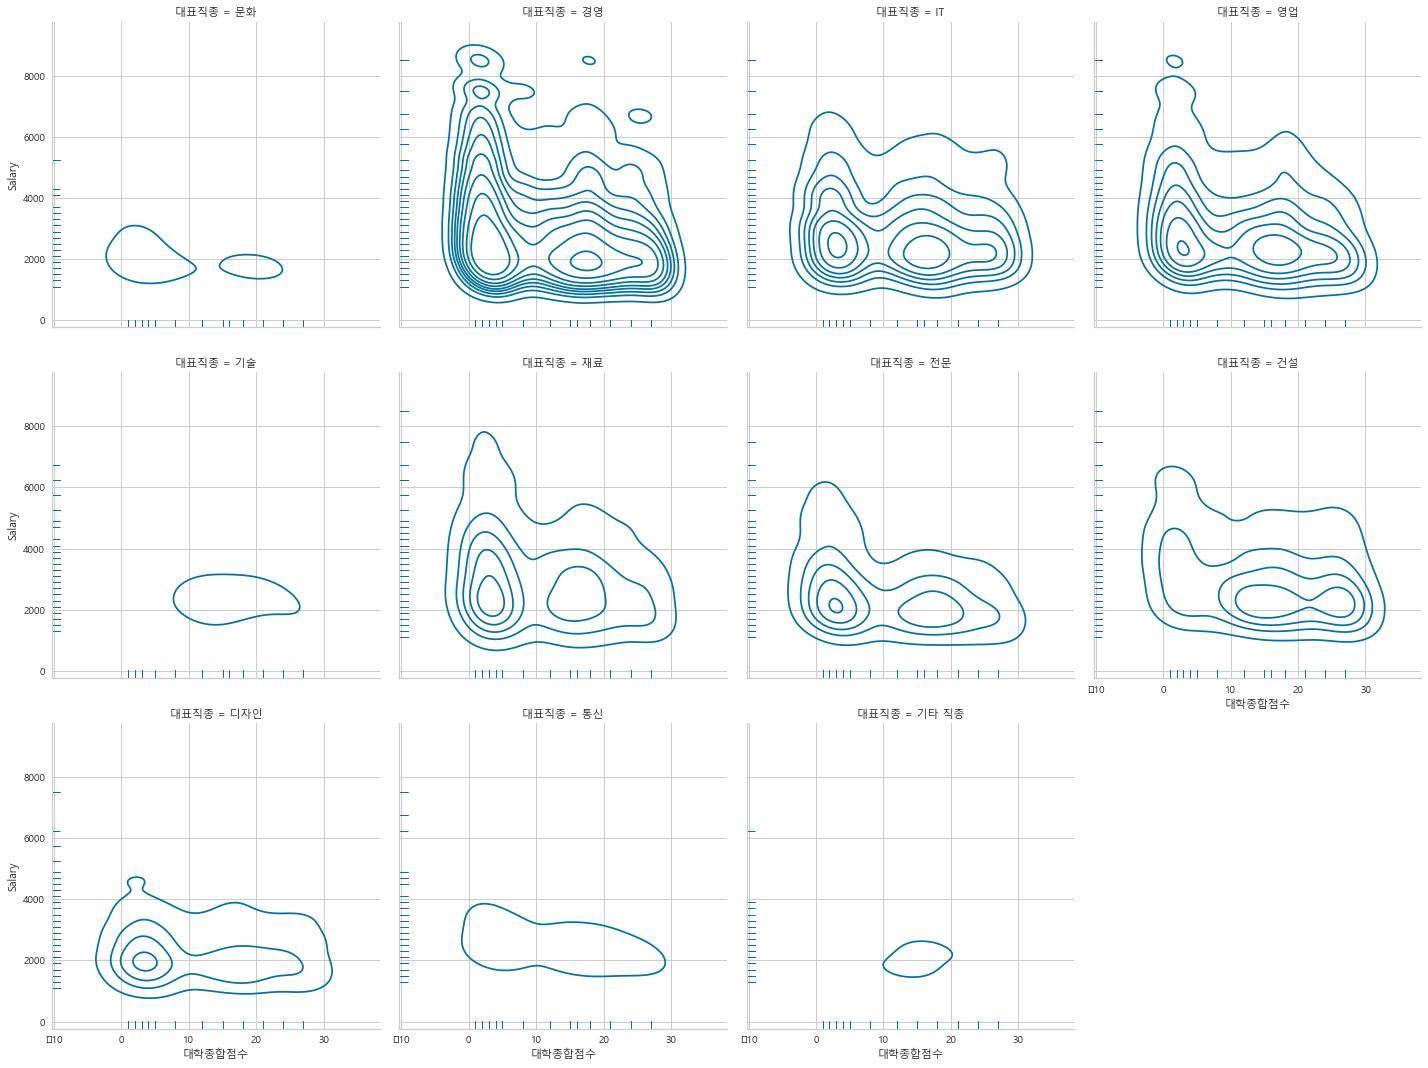

In [413]:
sns.displot(x = '대학종합점수', y = 'Salary', data=Xy, kind = 'kde', rug=True, col = '대표직종', col_wrap = 4)

# Transformation

### Dummy Transformation - `직종`, `세부직종`, `근무형태`, `근무지역`, `출신대학`, `대학전공`, `어학시험`

- 더미변환은 `train`, `test`에 feature별 unique category의 개수가 다를 경우 데이터 형태가 달라짐.
- 따라서, `train`, `test`를 concat한 후 encoding 진행해야함.

#### 카테고리변수 더미변환

In [414]:
categorical_cols = ['근무형태', '출신대학', '대학전공', '어학시험', '근무지역해외포함', '자격증', '직무태그해외관련']
categorical_cols2 = ['직종', '근무지역', '표준화직무태그'] # '대표근무지역', '대표직종', '대표직종2'
numeric_cols = ['근무경력', '대학성적', '근무지역개수', '근무형태개수','직종개수', '세부직종개수', 
                '직무태그개수', '경력인정점수', '대학종합점수', '직종대비직무태그수']
ordinal_cols = ['근무형태등급', '출신대학등급', '출신대학지역']
pca_cols = ['직무태그', '세부직종']

In [415]:
set(X.columns) - set(categorical_cols + categorical_cols2 + numeric_cols + ordinal_cols + pca_cols)

{'대표근무지역', '대표직종', '대표직종2'}

In [416]:
input_train = pd.DataFrame(index = X_train.index, data = y_train)
input_test = pd.DataFrame(index = X_test.index)

In [417]:
# categorcial_cols
encoder = OneHotEncoder()
encoder.fit(X[categorical_cols])

X_dummy = pd.DataFrame(columns = encoder.get_feature_names(), data = encoder.transform(X[categorical_cols]).toarray(), index=X.index)
input_train = pd.concat([input_train, X_dummy], axis=1)

In [418]:
# categorcial_cols2
for col in categorical_cols2:
    vectorizer = CountVectorizer(token_pattern='[a-zA-Z가-힣 ]+', min_df=25)
    X_cv_vecs = vectorizer.fit_transform(X[col]).toarray()
    types = vectorizer.get_feature_names()
    cols = [col+'_'+t for t in types]
    X_cv_dummy = pd.DataFrame(columns = cols, data = X_cv_vecs, index=X.index)
    input_train = pd.concat([input_train, X_cv_dummy], axis=1)

### PCA Transformation - `직무태그`, `세부직종`

- PCA components의 개수는 30 ~ 50이 적합. 너무 많으면 성능감소

In [419]:
n_components = 50

for col in pca_cols:
    vectorizer = CountVectorizer(min_df=15)
    
    pca = PCA(n_components)
    pca_vecs =pca.fit_transform(vectorizer.fit_transform(X[col]).toarray())
    
    cols = [f'{col}_pca_'+str(i) for i in range(n_components)]
    X_pca = pd.DataFrame(columns = cols, data = pca_vecs, index = X.index)
    input_train = pd.concat([input_train, X_pca], axis=1)

In [420]:
input_train = pd.concat([input_train, X[numeric_cols]], axis=1)

In [421]:
input_train = pd.concat([input_train, X[ordinal_cols]], axis=1)

In [422]:
input_train.shape

(27618, 370)

## Scaling

### PowerTransformer

In [423]:
scaler = MinMaxScaler()
input_train[numeric_cols] = scaler.fit_transform(input_train[numeric_cols])

# transformer = PowerTransformer()
# input_train[numeric_cols] = transformer.fit_transform(input_train[numeric_cols])

### Standard Scaling for PCA components

In [424]:
scaler = StandardScaler()

pca_comp_cols = input_train.filter(like='pca').columns
input_train[pca_comp_cols] = scaler.fit_transform(input_train[pca_comp_cols])

# Modeling with Pycaret

In [425]:
def save_table(df, name=None):
    assert name
    with pd.ExcelWriter('exp_table.xlsx', engine='openpyxl', mode='a') as writer:
        df.to_excel(writer, sheet_name=name)

In [427]:
exp_name = 'new_features3_v3'

exp01 = setup(data = input_train.loc[X_train.index],
              target = 'Salary',
              train_size=0.80, 
              numeric_features=numeric_cols,
              ordinal_features={
                  '근무형태등급':[str(i) for i in range(6, 0, -1)], 
                  '출신대학등급':[str(i) for i in range(9, 0, -1)],
                  '출신대학지역':[str(i) for i in range(3, 0, -1)]
              },
              remove_multicollinearity=True,
              multicollinearity_threshold=0.8,
              feature_selection=True,
              remove_outliers=True,
              session_id = 123, 
             )

summary_df = pull().data
top2 = compare_models(n_select = 3, exclude = [
    'br', 'dt', 'par', 'huber', 'llar', 'knn', 'ada', 
    'en', 'lr', 'lar', 'omp', 'et', 'dummy', 
    'gbr', 'rf', 'ridge', 'lasso', 'xgboost'
])
exp_table = pull().reset_index(drop=True)
save_table(summary_df.join(exp_table), name=exp_name)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,578.5081,670276.4119,818.1760,0.5551,0.2647,0.2162,4.7660
lightgbm,Light Gradient Boosting Machine,586.3189,685330.7563,827.4472,0.5451,0.2681,0.2195,0.7370


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 2
INFO:logs:[<catboost.core.CatBoostRegressor object at 0x000001F6C6BD50A0>, LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)]
INFO:logs:compare_models() succesfully completed......................................


In [428]:
catboost = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,558.7665,631646.9047,794.7622,0.5388,0.2621,0.2139
1,606.5321,767391.8675,876.0091,0.5243,0.2737,0.2199
2,564.7109,672039.2777,819.7800,0.5894,0.2626,0.2120
3,589.6664,729021.9188,853.8278,0.5305,0.2673,0.2148
4,567.0904,603964.6344,777.1516,0.5780,0.2576,0.2126
5,564.2893,635217.7100,797.0055,0.5416,0.2623,0.2152
6,573.7179,686883.4412,828.7843,0.5335,0.2643,0.2145
7,578.5190,617955.8617,786.1017,0.5995,0.2618,0.2185
8,590.1652,665861.3405,816.0033,0.5767,0.2667,0.2207


INFO:logs:create_model_container: 3
INFO:logs:master_model_container: 3
INFO:logs:display_container: 3
INFO:logs:<catboost.core.CatBoostRegressor object at 0x000001F6FA10E100>
INFO:logs:create_model() succesfully completed......................................


### Tuning

In [ ]:
tuned_caboost = tune_model(catboost, 
                           search_library = 'optuna', 
                           optimize='MSE', 
                           choose_better=True, 
                           early_stopping=True, 
                           n_iter=100)

INFO:logs:Initializing tune_model()
INFO:logs:tune_model(estimator=<catboost.core.CatBoostRegressor object at 0x000001F6FA10E100>, fold=None, round=4, n_iter=100, custom_grid=None, optimize=MSE, custom_scorer=None, search_library=optuna, search_algorithm=None, early_stopping=True, early_stopping_max_iters=10, choose_better=True, fit_kwargs=None, groups=None, return_tuner=False, verbose=True, tuner_verbose=True, display=None, return_train_score=False, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor


IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:09:31
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Regressor


,Fold,MAE,MSE,RMSE,R2,RMSLE,MAPE


INFO:logs:Copying training dataset
INFO:logs:Checking base model
INFO:logs:Base model : CatBoost Regressor
INFO:logs:Declaring metric variables
INFO:logs:Defining Hyperparameters
INFO:logs:Tuning with n_jobs=-1
INFO:logs:Initializing optuna.integration.OptunaSearchCV
INFO:logs:can_partial_fit: False, can_warm_start: False, is_xgboost: False
[I 2022-12-05 19:09:32,226] Searching the best hyperparameters using 12593 samples...
[W 2022-12-05 19:09:33,374] The parameter 'actual_estimator__eta' in trial#10 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom lo

In [ ]:
ensemble_model(tuned_caboost, choose_better = True)

### Ensemble

#### Blending

In [ ]:
blender = blend_models(estimator_list = [catboost, lighgbm], weights=[.7, .3])

#### Stacking

### Finalizing Model

In [ ]:
final_model = finalize_model(blender)
preds = predict_model(final_model, data = final_test)

In [ ]:
evaluate_model(final_model)

In [62]:
model_name = 'CatBoost_cv50'
now = datetime.now().strftime('%y%m%d-%H%M')

submission['Salary'] = preds['Label']
submission.to_csv(f'submission/{model_name}_{now}.csv', index=False)

### Powermean

In [ ]:
# 사용법: 
# 1) 스크립트를 실행하기 전에 submissions 폴더를 먼저 만듭니다. 
# 2) 앙상블할 submission 화일을 submissions 폴더에 저장합니다.
# 3) 실행하면 현재 폴더에 앙상블한 submission 화일이 생성됩니다.

P = 1.5           # 이 값에 따라 성능이 달라짐 (P=1: 산술평균, P>1: 멱평균)
USE_RANK = False    # 확률을 순위로 변경하여 앙상블 하는가 여부
WEIGHT = [] #[0.79909, 0.80767, 0.80108, 0.80711]  # 가중치 지정안할 경우: WEIGHT = []

In [ ]:
# 아래 폴더가 있다는 가정 하에 수행
folder = 'submission'
nf = 0
for f in os.listdir(folder):
    ext = os.path.splitext(f)[-1]
    if ext == '.csv': 
        s = pd.read_csv(folder+"/"+f)
        if USE_RANK: 
            s.iloc[:,1] = s.iloc[:,1].rank() / s.shape[0]
        if len(WEIGHT) > 0:
            s.iloc[:,1] = s.iloc[:,1] * (WEIGHT[nf] / sum(WEIGHT))       
    else: 
        continue
    if nf == 0: 
        slist = s
    else: 
        slist = pd.merge(slist, s, on="ID")
    nf += 1
    
if nf >= 2:
    pred = 0
    for j in range(nf):
        pred = pred + slist.iloc[:,j+1]**P 
    pred = pred / nf    
    pred = pred**(1/P)  
    t = pd.Timestamp.now()
    fname = f"submission/p{P}mean_submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
    pd.DataFrame({'ID': slist.ID, 'Salary': pred}).to_csv(fname, index=False)
    print(f"'{fname}' is ready to submit.") 
    
    sns.distplot(pd.DataFrame(pred))       

In [ ]:
final_catboost